## Import

In [1]:
import anndata
import pandas as pd
import numpy as np
import scanpy as sc
import os
import matplotlib.pyplot as plt

In [8]:
output_path = "output_phenotypes"

## Load

In [3]:
input_path = "../input data/crca_xenium.h5ad"
adata = sc.read_h5ad(input_path)

In [4]:
adata

AnnData object with n_obs × n_vars = 3706544 × 380
    obs: 'cell_id', 'name', 'slide', 'tissue_region', 'patient_id', 'crca_id', 'crca_patient_id', 'msi_status', 'stage', 'age', 'sex', 'KRAS', 'BRAF', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segm_meth', 'segmentation_method', 'region', 'z_level', 'cell_labels', 'transcript_density', 'mean_neighbor_dist', 'scvi130_nb_leiden_2.5', 'scvi130_nb_leiden_3.8', 'anno_notes', 'celltype', 'celltype_sub', 'CN', 'Neutrophil', 'Niche'
    uns: 'colors', 'delaunayr50_nb', 'delaunayr50_neighbors', 'log1p', 'nichecompass_umap', 'scvi130_nb', 'scvi130_nb_leiden_1_rank', 'scvi130_nb_umap', 'spatialdata_attrs'
    obsm: 'delaunayr50', 'nichecompass_umap', 'norm_pca', 'norm_pca_nb_umap', 'scvi', 'scvi130_nb_umap', 'spatial'
    varm: 'nichecompass_gp_sources', 'nichecompass_gp_

## T cells sub-annotation

In [5]:
t_cells = adata[adata.obs['celltype']=='T cell'].copy()

In [6]:
key = 't_cell_neighbors'
sc.pp.neighbors(t_cells, use_rep='scvi', key_added=key)
sc.tl.umap(t_cells, neighbors_key=key)

/home/rossi/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Compute clusters

In [7]:
key = 't_cell_neighbors'
n_iterations = 5
resolutions = [float(x) for x in '1,1.25,1.5'.split(',')]

for res in resolutions:
    sc.tl.leiden(t_cells, resolution=res, neighbors_key=key, key_added=key+'_leiden_'+str(res), n_iterations=n_iterations)

/tmp/ipykernel_3338539/2075156346.py:6: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(t_cells, resolution=res, neighbors_key=key, key_added=key+'_leiden_'+str(res), n_iterations=n_iterations)
IOStream.flush timed out


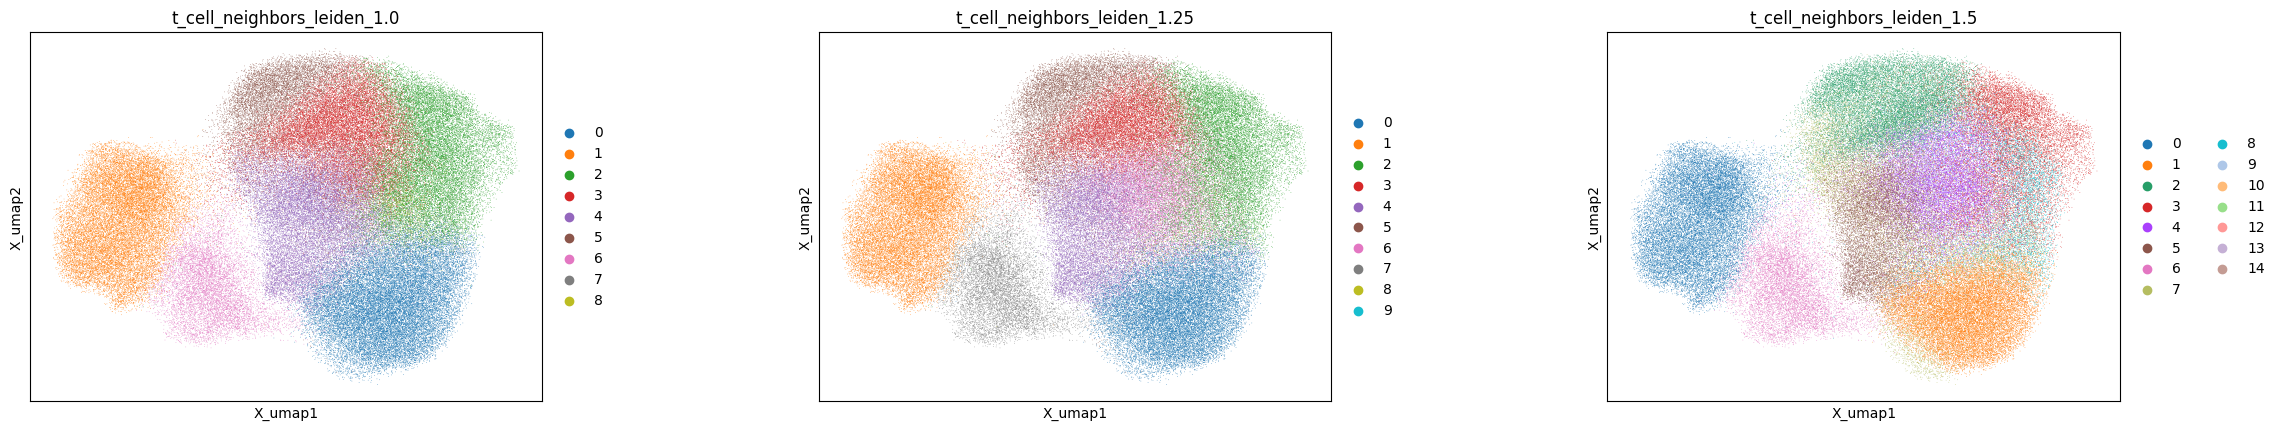

In [8]:
color_keys = [f"{key}_leiden_{res}" for res in resolutions]

sc.pl.embedding(
    t_cells,
    basis="X_umap",
    color=color_keys,
    ncols=4,           
    wspace=0.4,       
)

In [9]:
t_cells.write(os.path.join(output_path, 't_cells.h5ad'))

In [6]:
t_cells = sc.read_h5ad(os.path.join(output_path, 't_cells.h5ad'))

### Resolution = 1.0

In [11]:
res = 1.0
key = 't_cell_neighbors'
group = f"{key}_leiden_{res}"

In [27]:
t_cells.obs[group].value_counts()

t_cell_neighbors_leiden_1.0
0    26230
1    21763
2    20884
3    20201
4    19865
5    10497
6     9239
7     2124
8     1083
Name: count, dtype: int64

#### T cells markers

In [95]:
marker_dict = {
    "Pan - T cell": ["CD3E","FOS","TBX21","FAS","CD28","CD3D","CD2"],
    "Pan-Cycling": ["MKI67", "CDK1"],
    "Activation": ["JUN","STAT1"],
    "Stem-like": ['TCF7'],
    "Naive": ["SELL"],
    "CD4": ["CD4"],
    "Treg": ["FOXP3", "IL2RA", "CTLA4","TIGIT"],
    "Exhausted / Regulatory": ["ENTPD1","PDCD1","LAG3","HAVCR2"],
    "CD8": ["CD8A","CD8B","TOX"],
    "Cytotoxic": ["ID2","EOMES","FASLG","PRF1","GZMA"],
    "Effector": ["GZMK","BATF3","CCR2"],
    "NK": ["NKG7","FCGR3A"],
    "ILC": ["KIT","RORC","IL1R1"],
    "Plasma cell - contaminants" : ['IGKC', 'IGHG1', 'JCHAIN', 'IGHG4', 'IGHG3', 'IGHGP', 'IGHG2', 'IGHM', 'XBP1'],
    "Stromal - contaminants" : ['VCAN', 'LUM']
    #"tcell_markers" : ['TCF7', 'JUN', 'IL2RA', 'MKI67', 'TOX','FOS','ID2','STAT1','EOMES','BATF3','TBX21','FASLG','FAS','GZMA','GZMK','PRF1','ENTPD1','FOXP3','PDCD1','LAG3','HAVCR2','TIGIT','SELL','CCR2']
}

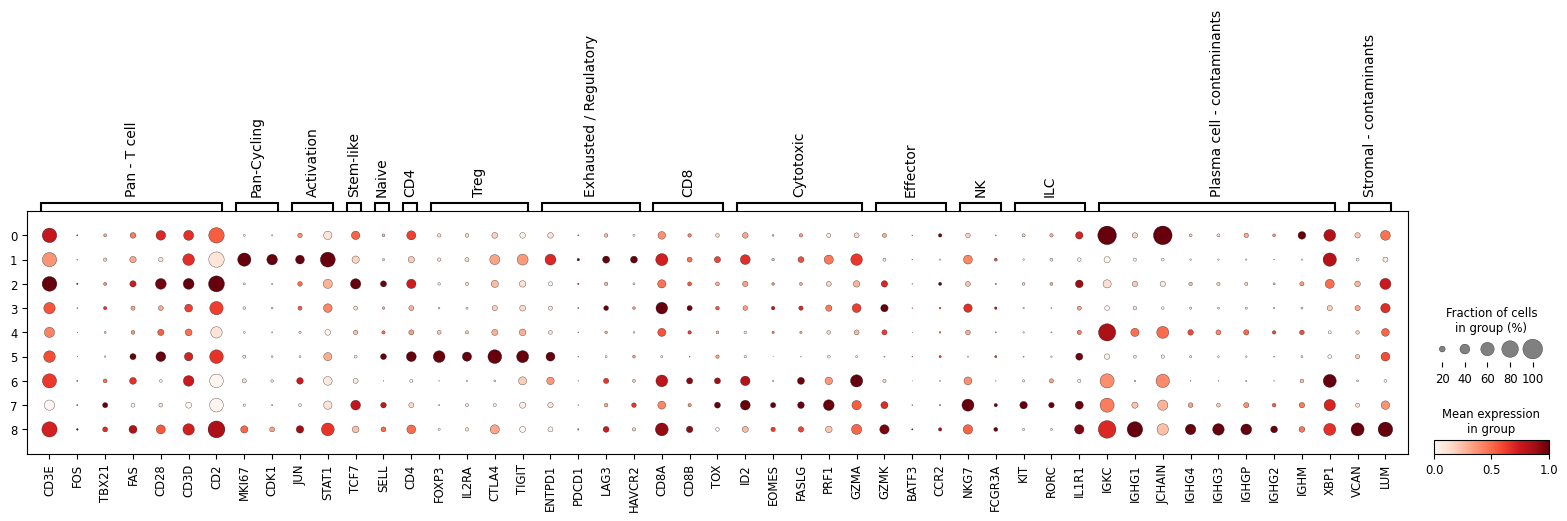

In [96]:
sc.pl.dotplot(
    t_cells,
    marker_dict,
    groupby=f"{key}_leiden_{res}",  
    standard_scale="var",
    dendrogram=False,
    #swap_axes=True
)

#### Clusters markers

In [8]:
sc.tl.rank_genes_groups(t_cells, f"{key}_leiden_{res}", method='wilcoxon', key_added=f'rank_genes_groups_leiden_{res}')

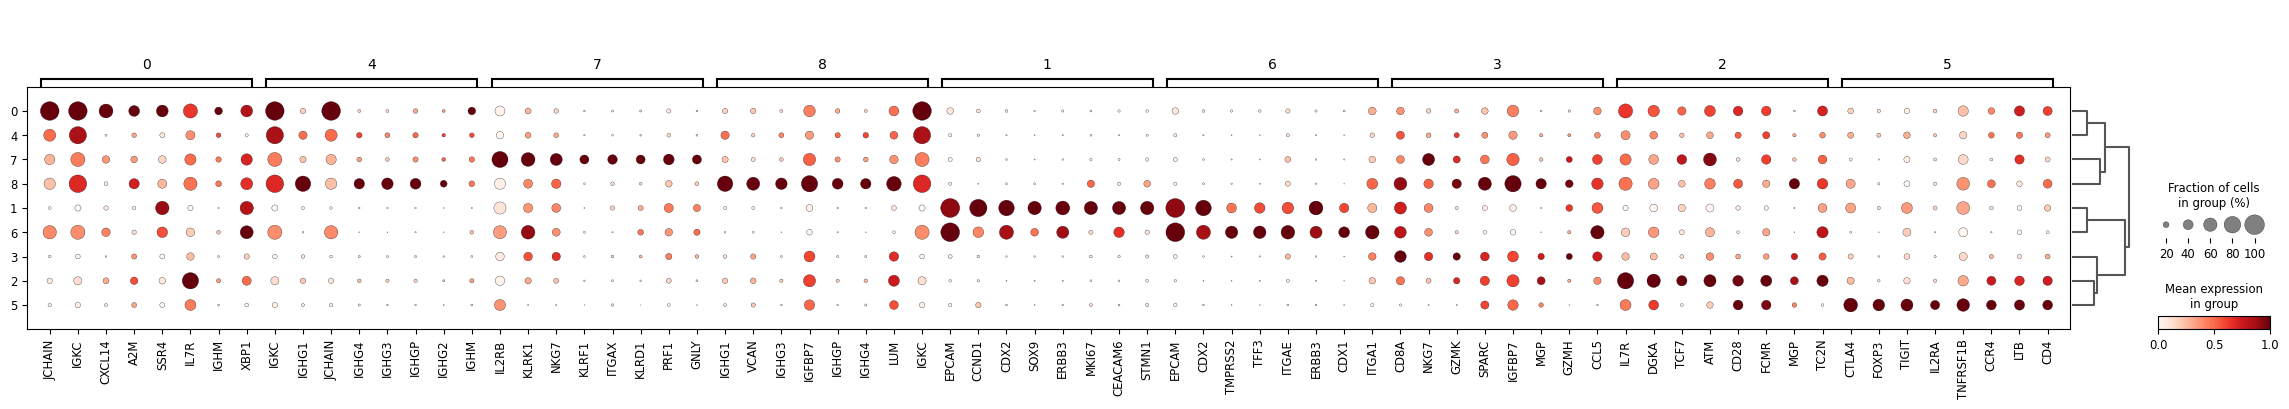

In [11]:
sc.pl.rank_genes_groups_dotplot(
    t_cells,
    key=f'rank_genes_groups_leiden_{res}',
    n_genes=8,       
    groupby=f"{key}_leiden_{res}",
    standard_scale='var', 
    show=True
)

In [20]:
rank_genes = t_cells.uns[f"rank_genes_groups_leiden_{res}"]
groups = rank_genes['names'].dtype.names  
cluster_marker_dict = {
    group: list(rank_genes['names'][group][:8])
    for group in groups
}
cluster_marker_dict

{'0': ['JCHAIN', 'IGKC', 'CXCL14', 'A2M', 'SSR4', 'IL7R', 'IGHM', 'XBP1'],
 '1': ['EPCAM', 'CCND1', 'CDX2', 'SOX9', 'ERBB3', 'MKI67', 'CEACAM6', 'STMN1'],
 '2': ['IL7R', 'DGKA', 'TCF7', 'ATM', 'CD28', 'FCMR', 'MGP', 'TC2N'],
 '3': ['CD8A', 'NKG7', 'GZMK', 'SPARC', 'IGFBP7', 'MGP', 'GZMH', 'CCL5'],
 '4': ['IGKC', 'IGHG1', 'JCHAIN', 'IGHG4', 'IGHG3', 'IGHGP', 'IGHG2', 'IGHM'],
 '5': ['CTLA4', 'FOXP3', 'TIGIT', 'IL2RA', 'TNFRSF1B', 'CCR4', 'LTB', 'CD4'],
 '6': ['EPCAM', 'CDX2', 'TMPRSS2', 'TFF3', 'ITGAE', 'ERBB3', 'CDX1', 'ITGA1'],
 '7': ['IL2RB', 'KLRK1', 'NKG7', 'KLRF1', 'ITGAX', 'KLRD1', 'PRF1', 'GNLY'],
 '8': ['IGHG1', 'VCAN', 'IGHG3', 'IGFBP7', 'IGHGP', 'IGHG4', 'LUM', 'IGKC']}

In [38]:
def fraction_with_at_least_N_markers(adata, markers, cluster_key, N=2, thresh=0):
    present = [g for g in markers if g in adata.var_names]
    # build boolean matrix cells x markers
    mat = []
    for g in present:
        loc = adata.var_names.get_loc(g)
        col = adata.X[:, loc].toarray().ravel() if hasattr(adata.X, "toarray") else np.ravel(adata.X[:, loc])
        mat.append(col > thresh)
    mat = np.vstack(mat).T  # shape n_cells x n_markers
    npos = mat.sum(axis=1)
    df = pd.DataFrame({cluster_key: adata.obs[cluster_key].values, "npos": npos})
    return df.groupby(cluster_key)["npos"].apply(lambda x: (x >= N).sum()/len(x))

fraction_with_at_least_N_markers(t_cells, marker_dict["Pan - T cell"], cluster_col, N=2, thresh=0)

/tmp/ipykernel_2250707/3965277123.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return df.groupby(cluster_key)["npos"].apply(lambda x: (x >= N).sum()/len(x))


t_cell_neighbors_leiden_1.0
0    0.752383
1    0.717272
2    0.794292
3    0.545221
4    0.463982
5    0.622273
6    0.673558
7    0.492938
8    0.835642
Name: npos, dtype: float64

## Comparison with B and Plasma cells gene expression

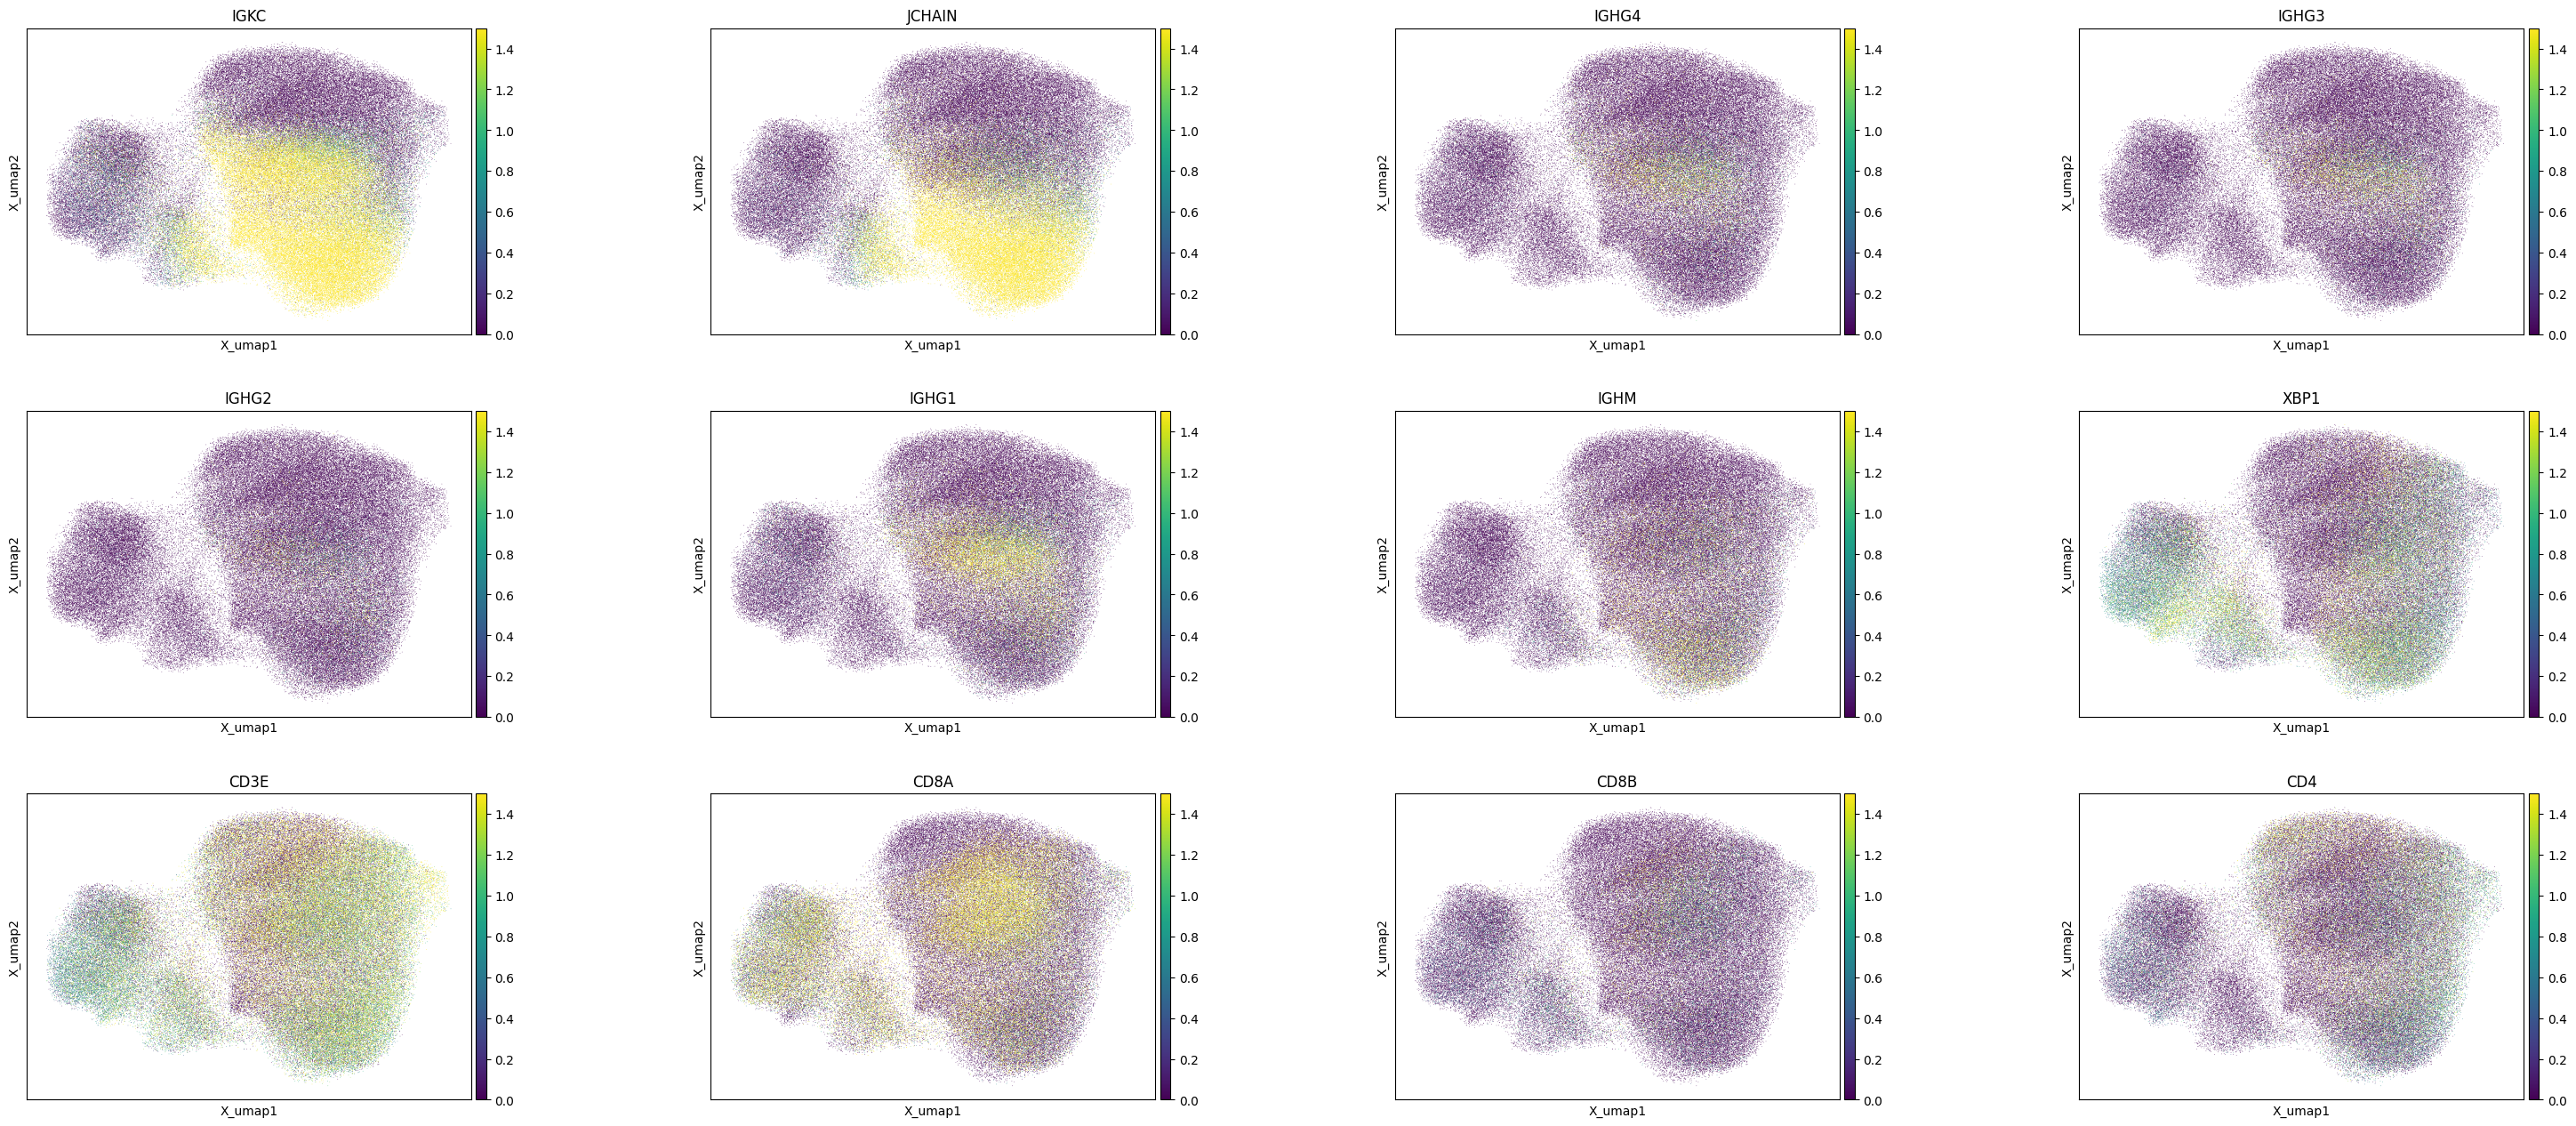

In [92]:
# plot of the plasma cell - contaminant
sc.pl.embedding(
    t_cells,
    basis="X_umap",
    color= ['IGKC', 'JCHAIN', 'IGHG4', 'IGHG3', 'IGHG2', 'IGHG1', 'IGHM', 'XBP1', 'CD3E', 'CD8A', 'CD8B', 'CD4'],
    wspace=0.4,       
    vmax=1.5
)

In [7]:
t_cells.obs['is_cluster4'] = t_cells.obs[group] == '4'
t_cells.obs['is_cluster0'] = t_cells.obs[group] == '0'
t_cells.obs['is_cluster8'] = t_cells.obs[group] == '8'

In [8]:
cluster4_ids = t_cells.obs.loc[t_cells.obs['is_cluster4'], 'cell_id']
cluster0_ids = t_cells.obs.loc[t_cells.obs['is_cluster0'], 'cell_id']
cluster8_ids = t_cells.obs.loc[t_cells.obs['is_cluster8'], 'cell_id']
adata.obs['is_cluster4'] = adata.obs['cell_id'].isin(cluster4_ids).astype(bool)
adata.obs['is_cluster0'] = adata.obs['cell_id'].isin(cluster0_ids).astype(bool)
adata.obs['is_cluster8'] = adata.obs['cell_id'].isin(cluster8_ids).astype(bool)

In [9]:
Bcell = adata.obs['celltype'] == 'B cell'
cl4 = adata.obs['is_cluster4'] == True
cl0 = adata.obs['is_cluster0'] == True
cl8 = adata.obs['is_cluster8'] == True
Plasmacell = adata.obs['celltype'] == 'Plasma cell'

In [10]:
adata.obs['plasmaB_vs_cluster'] = 'other'
adata.obs.loc[Bcell, 'plasmaB_vs_cluster'] = 'B cell'
adata.obs.loc[cl4, 'plasmaB_vs_cluster'] = 'Cluster 4'
adata.obs.loc[cl0, 'plasmaB_vs_cluster'] = 'Cluster 0'
adata.obs.loc[cl8, 'plasmaB_vs_cluster'] = 'Cluster 8'
adata.obs.loc[Plasmacell, 'plasmaB_vs_cluster'] = 'Plasma cell'

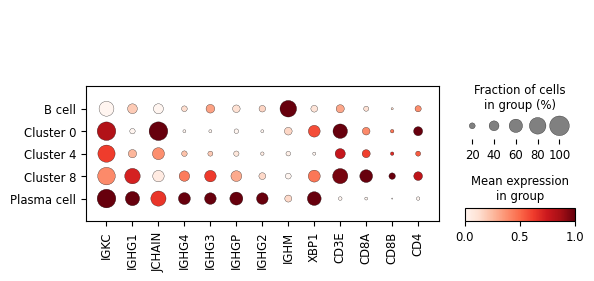

In [11]:
adata_sub = adata[adata.obs['plasmaB_vs_cluster'].isin(['B cell', 'Plasma cell', 'Cluster 4', 'Cluster 0', 'Cluster 8'])].copy()
genes = ['IGKC', 'IGHG1', 'JCHAIN', 'IGHG4', 'IGHG3', 'IGHGP', 'IGHG2', 'IGHM', 'XBP1', 'CD3E', 'CD8A', 'CD8B', 'CD4']

sc.pl.dotplot(
    adata_sub,
    var_names=genes,
    groupby='plasmaB_vs_cluster',
    standard_scale='var'
)

IGKC is highly expressed in certain T cell subsets, such as CD8+/CD4+ mixed T helper cells in lung cancer metastases, 
and it is also linked to the effectiveness of immunotherapies and a better prognosis in various cancers, likely due to the presence of IGKC-expressing immune cells. 
https://bioturing.medium.com/immunoglobulin-genes-up-regulated-in-lung-adenocarcinoma-infiltrating-t-cells-a-report-from-e265643d9634 


Interestingly, the T cell-CCL4L2Hi cells also expressed a high level of selected immunoglobulin genes including JCHAIN, IGKC, IGHM https://www.medrxiv.org/content/10.1101/2022.07.03.22277129v1.full


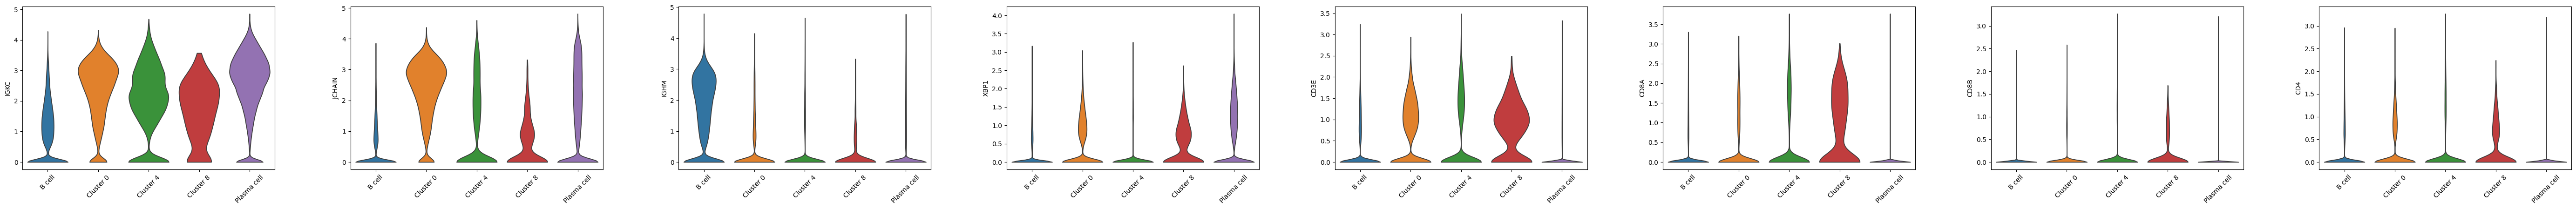

In [12]:
sc.pl.violin(
    adata_sub,
    keys=['IGKC','JCHAIN','IGHM', 'XBP1', 'CD3E', 'CD8A', 'CD8B', 'CD4'],
    groupby='plasmaB_vs_cluster',
    rotation=45,
    stripplot=False,   # no dots
    multi_panel=True,  # one panel per each gene
)

### Select only double positive (T cell genes + and Plasma B cell genes +) cells in cluster 4 

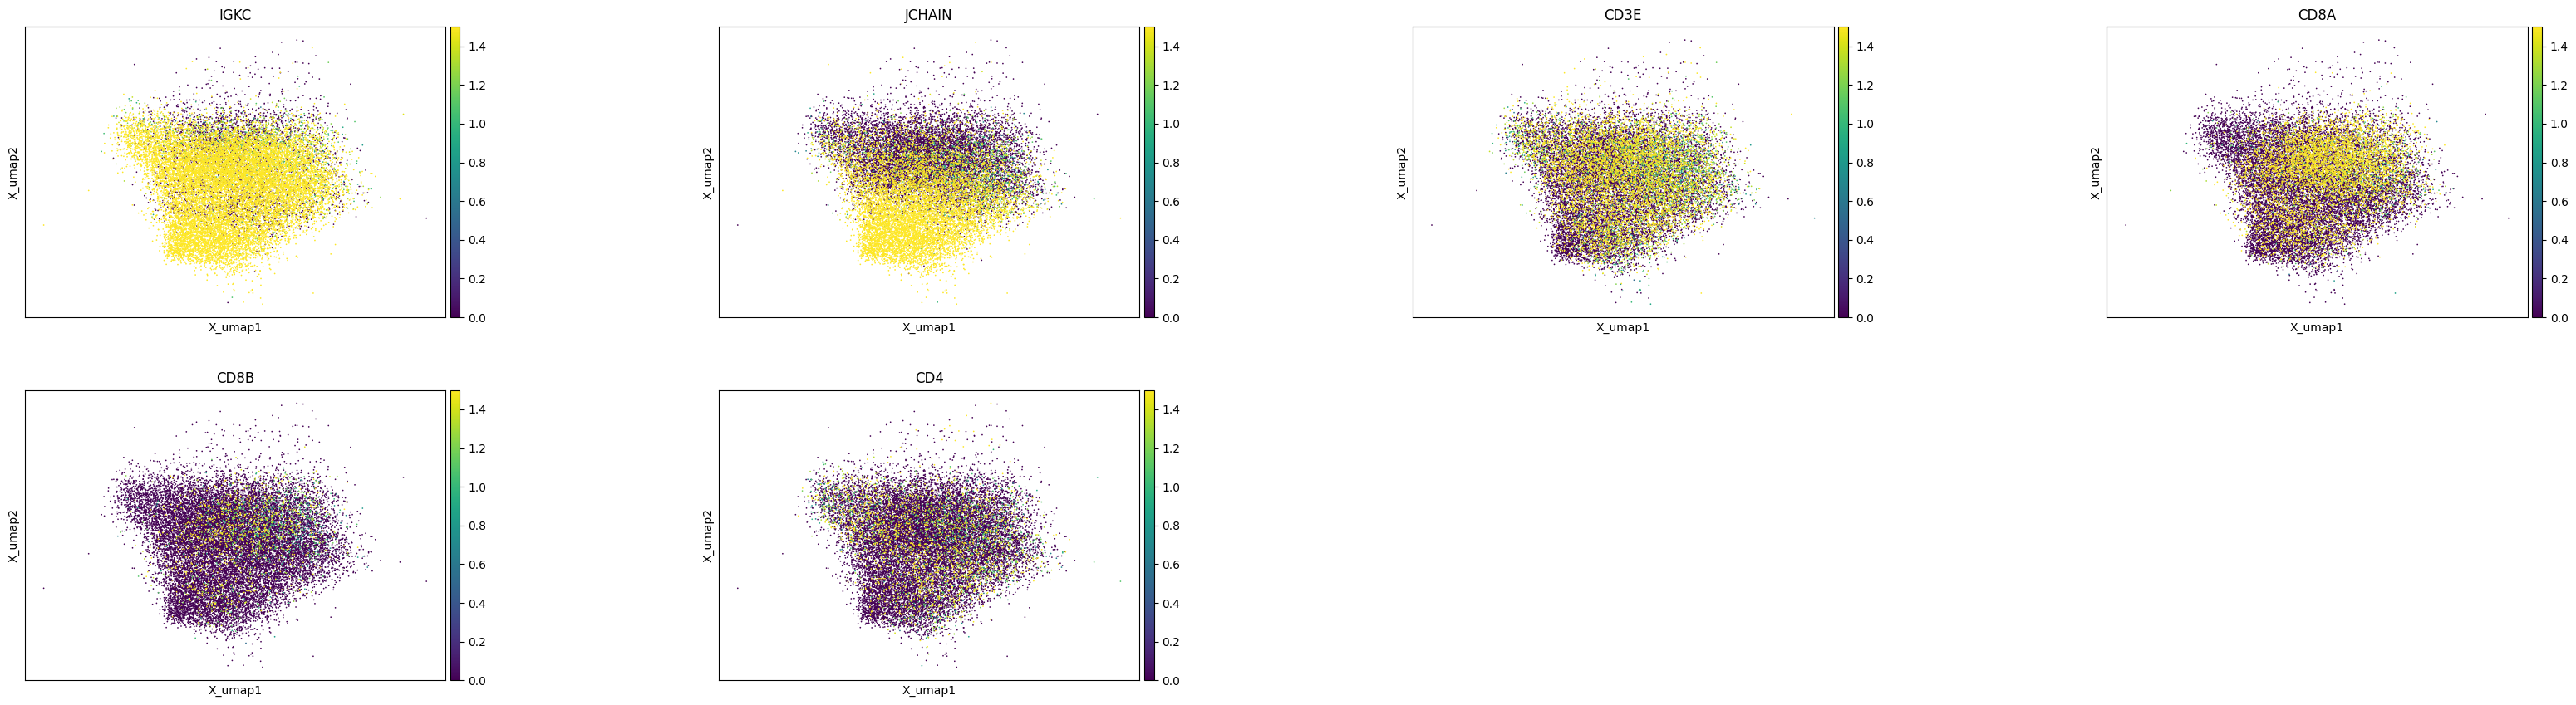

In [98]:
adata_sub_cl4 = t_cells[t_cells.obs[group] == '4'].copy()
sc.pl.embedding(
    adata_sub_cl4,
    basis="X_umap",
    color=['IGKC', 'JCHAIN', 'CD3E', 'CD8A', 'CD8B', 'CD4'],
    vmax=1.5,
    wspace=0.5
)

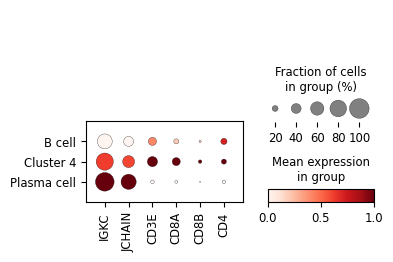

In [104]:
adata_sub = adata[adata.obs['plasmaB_vs_cluster'].isin(['B cell', 'Plasma cell', 'Cluster 4'])].copy()
genes = ['IGKC', 'JCHAIN', 'CD3E', 'CD8A', 'CD8B', 'CD4']

sc.pl.dotplot(
    adata_sub,
    var_names=genes,
    groupby='plasmaB_vs_cluster',
    standard_scale='var'
)

In [49]:
threshold = 0.5  # on the expression

expr_IGKC = adata_sub_cl4[:, 'IGKC'].X.toarray().flatten()
expr_JCHAIN = adata_sub_cl4[:, 'JCHAIN'].X.toarray().flatten()
expr_CD3E = adata_sub_cl4[:, 'CD3E'].X.toarray().flatten()

is_IGKC_pos = expr_IGKC > threshold
is_JCHAIN_pos = expr_JCHAIN > threshold
is_CD3E_pos = expr_CD3E > threshold

# Double positive for T cell gene CD3E and Plasma cell genes IGKC and JCHAIN
double_pos_mask = is_IGKC_pos & is_JCHAIN_pos & is_CD3E_pos 

# Subset 
adata_sub_cl4_doublepos = adata_sub_cl4[double_pos_mask].copy() # 3562 out of 19865 cells are double positive

In [54]:
adata_sub_cl4.obs['is_double_pos'] = double_pos_mask
double_pos_ids = adata_sub_cl4.obs.loc[adata_sub_cl4.obs['is_double_pos'], 'cell_id']
adata.obs['is_double_pos'] = adata.obs['cell_id'].isin(double_pos_ids).astype(bool)

In [55]:
doublepos = adata.obs['is_double_pos'] == True

adata.obs['b_vs_doublepos'] = 'other'
adata.obs.loc[Bcell, 'b_vs_doublepos'] = 'B cell'
adata.obs.loc[doublepos, 'b_vs_doublepos'] = 'CD3E+IGKC+JCHAIN+ T cell'
adata.obs.loc[Plasmacell, 'b_vs_doublepos'] = 'Plasma cell'

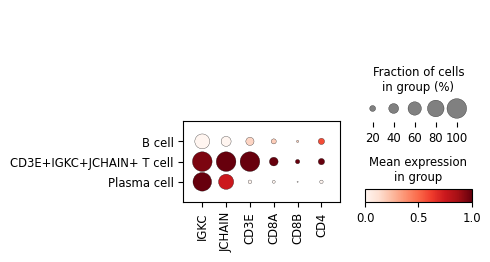

In [101]:
adata_sub = adata[adata.obs['b_vs_doublepos'].isin(['B cell', 'CD3E+IGKC+JCHAIN+ T cell', 'Plasma cell'])].copy()
genes = ['IGKC', 'JCHAIN', 'CD3E', 'CD8A', 'CD8B', 'CD4']

sc.pl.dotplot(
    adata_sub,
    var_names=genes,
    groupby='b_vs_doublepos',
    standard_scale='var'
)

### Select only Plasma cell genes + T cells

In [99]:
threshold = 0.5  # on the expression

#expr_IGKC = adata_sub_cl4[:, 'IGKC'].X.toarray().flatten()
#expr_JCHAIN = adata_sub_cl4[:, 'JCHAIN'].X.toarray().flatten()
#expr_CD3E = adata_sub_cl4[:, 'CD3E'].X.toarray().flatten()

#is_IGKC_pos = expr_IGKC > threshold
#is_JCHAIN_pos = expr_JCHAIN > threshold
is_CD3E_neg = expr_CD3E < threshold

plasma_pos_mask = is_IGKC_pos & is_JCHAIN_pos & is_CD3E_neg 

# Subset 
adata_sub_cl4_doublepos = adata_sub_cl4[plasma_pos_mask].copy() # 4926 cells

In [59]:
adata_sub_cl4.obs['is_plasma_pos'] = plasma_pos_mask
plasma_pos_ids = adata_sub_cl4.obs.loc[adata_sub_cl4.obs['is_plasma_pos'], 'cell_id']
adata.obs['is_plasma_pos'] = adata.obs['cell_id'].isin(plasma_pos_ids).astype(bool)

In [62]:
plasmapos = adata.obs['is_plasma_pos'] == True

adata.obs['b_vs_plasmapos'] = 'other'
adata.obs.loc[Bcell, 'b_vs_plasmapos'] = 'B cell'
adata.obs.loc[plasmapos, 'b_vs_plasmapos'] = 'CD3E-IGKC+JCHAIN+ T cell'
adata.obs.loc[Plasmacell, 'b_vs_plasmapos'] = 'Plasma cell'

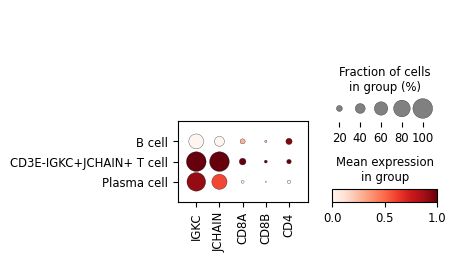

In [103]:
adata_sub = adata[adata.obs['b_vs_plasmapos'].isin(['B cell', 'CD3E-IGKC+JCHAIN+ T cell', 'Plasma cell'])].copy()
genes = ['IGKC', 'JCHAIN', 'CD8A', 'CD8B', 'CD4']

sc.pl.dotplot(
    adata_sub,
    var_names=genes,
    groupby='b_vs_plasmapos',
    standard_scale='var'
)

## Proposed annotation

In [13]:
annotation_dict = {
    '0':'CD4',
    '1':'Cycling/Activated - CD8',
    '2':'Naive/Stem-like - CD4',
    '3':'CD8',
    '4':'Mixed B cell - T cell',
    '5':'Treg - CD4',
    '6':'CD8 effector',
    '7':'NK - ILC',
    '8':'CD8 effector'
}

In [14]:
cluster_key = f"{key}_leiden_{res}"
t_cells.obs[f"{cluster_key}_annotation"] = (
    t_cells.obs[cluster_key].astype(str).map(annotation_dict)
)

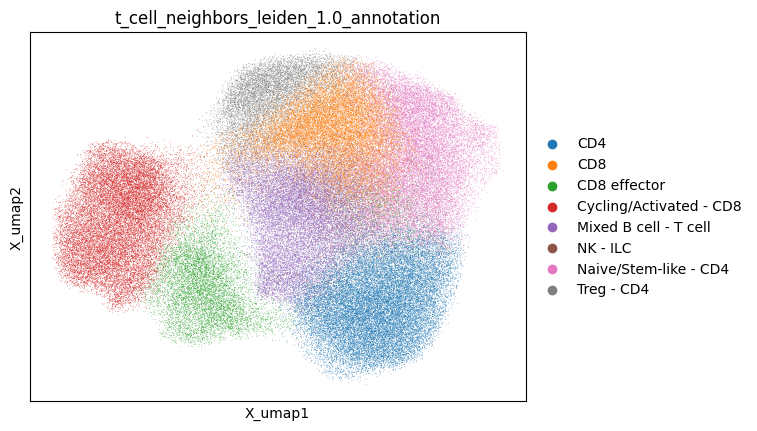

In [15]:
sc.pl.embedding(
    t_cells,
    basis="X_umap",
    color=f"{cluster_key}_annotation",
)

In [16]:
t_cells.obs['is_CD8'] = t_cells.obs[f"{cluster_key}_annotation"].isin(['CD8', 
                                                                     'CD8 effector', 
                                                                     'Cycling/Activated - CD8'
                                                                    ])

In [17]:
t_cells.write(os.path.join(output_path, 't_cells.h5ad'))

In [9]:
t_cells = sc.read_h5ad(os.path.join(output_path, 't_cells.h5ad'))

## Xenium Explorer export

In [22]:
adata.obs['group'] = adata.obs['celltype'].copy()

In [23]:
cluster_key = f"{key}_leiden_{res}"
mapping_dict = dict(
    zip(t_cells.obs['cell_id'], t_cells.obs[f"{cluster_key}_annotation"])
)

In [24]:
adata.obs['group'] = adata.obs['group'].astype(str)
adata.obs.loc[mapping_dict.keys(), 'group'] = pd.Series(mapping_dict)

In [25]:
df_annot = adata.obs[['cell_id', 'group']].copy()
df_annot.to_csv(os.path.join(output_path,'annotation_xe.csv'), index=False)

In [26]:
df_annot

cell_id        group
cell_id                            
hbbpmcfj-1  hbbpmcfj-1   Macrophage
mfiopagf-1  mfiopagf-1  Plasma cell
kihdapha-1  kihdapha-1   Fibroblast
clkhdnpe-1  clkhdnpe-1  Cancer cell
ifkanjbp-1  ifkanjbp-1  Plasma cell
...                ...          ...
hakbbkkb-1  hakbbkkb-1   Macrophage
fnkdmohn-1  fnkdmohn-1  Cancer cell
fdeiekgm-1  fdeiekgm-1   Fibroblast
kahbiihf-1  kahbiihf-1  Plasma cell
apmemhbe-1  apmemhbe-1  Cancer cell

[3706544 rows x 2 columns]